In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import os
import pickle
from scipy import stats
import scipy.signal as sigs
import scipy.stats
import cvxEDA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import regularizers
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Introduction 
<b>Objective of this experiment is to classify neural, stress and amusement using machine learning approach.</b>
In this study,I considered data from Empatica E4 device sensors - accelerometer sensors, body temperature, electroderma activity (EDA), blood volume pulse and chest mounted RespiBN's respiration sensor data to predict <b>stress, amusement and neutral</b> class. I have considered, all 15 subjects data from the mentioned sensors data for this explorations.





<b>Dataset Details:</b> The details of the dataset can be found in https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29. 

This multimodal sensor dataset contains 15 subjects (mean age of 27.5 ± 2.4 years) physiology sensors and movement sensors data.
Physiology sensors include blood volume pulse, electrocardiogram, electrodermal activity, electromyogram, respiration, body temperature and movement sensor include three axis accelerometer sensor data. Sensors were placed on two different body position both a wrist- and a chest-worn device. This dataset contains three classes/affective states -  neutral, stress, amuseemnt.

The RespiBAN device provides the following sensor data: electrocardiogram (ECG), electrodermal activity (EDA), electromyogram (EMG), respiration, body temperature, and three-axis acceleration. All signals are sampled at 700 Hz.
The Empatica E4 device provides the following sensor data: blood volume pulse (BVP, 64 Hz), electrodermal activity (EDA, 4 Hz), body temperature (4 Hz), and three-axis acceleration (32 Hz).

The dataset's readme-file contains all further details with respect to the dataset structure, data format (RespiBAN device, Empatica E4 device, synchronised data), study protocol, and the self-report questionnaires.


 

## Dataset Loading

In this exploration, I considered only wrist-worn sensors data and respiration data from chest mounted RespiBAN device, detail sensor list and sampling frequency are presented in the below table.

 Sensors | Abbreviation | Frequency |
--- | --- | ---
blood volume pulse | BVP | 64 Hz |
electrodermal activity | EDA | 4 Hz |
body temperature | TEMP |    4 Hz   |
three-axis acceleration | ACC |    32 Hz   |
Respiration | Resp | 700 Hz|





Dataset provided annotation for each samples at a sampling rate of 700Hz, for each of the subjects. maximum number of annotation are 4496100 for the subjects are provided. 


All sensors data are provided as pickle object for corresponding subject. Below method load the data from multiple sensors for each subject.

In [2]:
def load_data(sub_id):
    data_dir = "./WESAD/"
    name = f'S{sub_id}' # subject name i.e., S3 
    
        
    with open(os.path.join(data_dir, name) + '/' + name + '.pkl', 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    labels = data['label']
    
    #loading wrist sensors data - Empatica E4
    wrist_data = data['signal']['wrist']
    eda_df = pd.DataFrame(wrist_data['EDA'], columns=['eda'])
    bvp_df = pd.DataFrame(wrist_data['BVP'], columns=['bvp'])
    acc_df = pd.DataFrame(wrist_data['ACC'], columns=['x', 'y', 'z'])
    temp_df = pd.DataFrame(wrist_data['TEMP'], columns=['temp'])
    #chest mounted Resp data loading
    resp_df= pd.DataFrame(data['signal']['chest']['Resp'],columns=['resp'])
    label_df = pd.DataFrame(labels, columns=['label'])

    return eda_df,bvp_df,acc_df,temp_df,resp_df,label_df

In [3]:
#loading sampling frequency of the data for later use

fs = {'eda': 4,'bvp': 64, 'acc': 32, 'resp':700, 'temp': 4,'label': 700} #assign label frequency 700 - max freq 700

## Sensor Signals Processing 
In this experiemnt multimodal sensor data are considered and these sensors have different sampling frequency. Therefore, we need preprocessing the data to align all the sensors signal together. Since different sensors have different sampling rate, we assign index based on the sampling rate to each sample for the corresponding sensor signal and convert this index to datetime index for later joining all the data together.

``````python
def assign_index(data,fs):
    data.index = [(1 / fs) * i for i in range(len(data))]
    data.index = pd.to_datetime(data.index, unit='s') #converting to datetime
    return data
    
```

We also need to filters the signals as sensor signals are noisy. In this experiment, I used lowpass filter for EDA signal (since most of the frequency band lies within 5-6Hz) and FIR filter for accelerometer sensnors signals. Finally these sensors signals are joined together based on the index and save into the filtered signals for each subject. During this processing, we also extract phasic, tonic, sudomotor neuron activity (SMNA) from the filtered EDA sensor signals. 

In [4]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = sigs.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [5]:
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = sigs.lfilter(b, a, data)
    return y

In [6]:
def filter_signal_fir(data, cutoff=0.4, numtaps=64):
    f = cutoff / (fs['acc'] / 2.0)
    coeff = sigs.firwin(numtaps, f)

    return sigs.lfilter(coeff, 1, data)

In [7]:
def filter_accelerometer_signal(acc_df, cutoff=0.4, numtaps=64):
    length = len(acc_df.columns)
    for cname in acc_df.columns.tolist():
        f = cutoff / (fs['acc'] / 2.0)
        coeff = sigs.firwin(numtaps, f)
        acc_df[cname] = sigs.lfilter(coeff, 1, acc_df[cname].values) #filter accelerometer data
    return acc_df

In [8]:
def assign_index(data,fs):
    data.index = [(1 / fs) * i for i in range(len(data))]
    data.index = pd.to_datetime(data.index, unit='s') #converting to datetime
    return data

In [9]:
def preprocess_data():
    sub_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
    df_list =[]
    for sub in sub_ids:
        eda_df,bvp_df,acc_df,temp_df,resp_df,label_df = load_data(sub) 
    
        #filter accelerometer signals
        acc_df = filter_accelerometer_signal(acc_df)
        acc_df = assign_index(acc_df,fs['acc']) #create index using 
        eda_df['eda'] = lowpass_filter(eda_df['eda'], 1.0, fs['eda'])
        yn = (eda_df['eda'] - eda_df['eda'].mean()) / eda_df['eda'].std()
        r, p, t, l, d, e, obj = cvxEDA.cvxEDA(yn, 1. / fs['eda'])
        
        eda_df['EDA_tonic'] = t
        eda_df['EDA_phasic'] = r
        eda_df['EDA_smna'] = p
        
        eda_df = assign_index(eda_df,fs['eda']) #assign index based on sampling frequency
        
        bvp_df = assign_index(bvp_df,fs['bvp'])
        temp_df = assign_index(temp_df,fs['temp'])
        resp_df = assign_index(resp_df,fs['resp'])
        label_df = assign_index(label_df,fs['label'])
        
 
        #merge individual signals 
        df = eda_df.join(bvp_df, how='outer')
        df = df.join(temp_df, how='outer')
        df = df.join(acc_df, how='outer')
        df = df.join(resp_df, how='outer')
        df = df.join(label_df, how='outer')
        #filling missing labels values 
        df['label'] = df['label'].fillna(method='bfill')
        df.reset_index(drop=True, inplace=True)
        
        
        df.to_csv(f'data/filtered/S{sub}.csv',index=False)

In [10]:
preprocess_data()

## Feature Extraction

In this section, we computed standard statistical features mean, standard deviation, min, max features from the dataset for each annotatation. We use window size of 30 second to compute this statistics. We use sliding window based approach without overlapping of the signal. In addition to these features, we also compute blood volume pulse spectrogram and blood volume peak frequency from blood volume signal.

In [11]:
def compute_features(data,w_size,num_win,label):
    
    feat_list = []
    feat_names=None
    for i in range(num_win):
        
        frame = data[w_size * i: w_size * (i + 1)] #get frame
        _mean = np.mean(frame)
        _std = np.std(frame)
        _min = np.amin(frame)
        _max = np.amax(frame)

        features = {'mean': _mean, 'std': _std, 'min': _min, 'max': _max,
                    'label': label}

        
        x = pd.DataFrame(features).drop('label', axis=0)
        y = x['label'][0]
        x.drop('label', axis=1, inplace=True)

        
        if feat_names is None:
            feat_names = []
            for row in x.index:
                for col in x.columns:
                    feat_names.append('_'.join([row, col]))


        df_fet = pd.DataFrame(x.values.flatten()).T
        df_fet.columns = feat_names
        df_fet = pd.concat([df_fet, pd.DataFrame({'label': y}, index=[0])], axis=1)
        
        #compute blood volume pulse spectrogram
        bvp_sig = frame['bvp'].dropna()
        f, Pxx = sigs.periodogram(bvp_sig, fs=8)
        psd_dict = {amp: freq for amp, freq in zip(Pxx, f)}
        peak_freq = psd_dict[max(psd_dict.keys())]
        df_fet['bvp_peak_freq'] = peak_freq

             
        feat_list.append(df_fet)
                                  
    return pd.concat(feat_list)

In [12]:
def compute_subject_wise_features():
    sub_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

    seg_len = 30 #seconds
    for sub in sub_ids:
        #load data
        df = pd.read_csv(f'data/filtered/S{sub}.csv')
        #compute eda raw features
        
        gr_df = df.groupby('label')
        
        
        base_sig = gr_df.get_group(1)
        window_size = fs['label'] * seg_len
        n_base_win = int(len(base_sig) / (window_size))
        base_feats = compute_features(base_sig,window_size,n_base_win,1) # base as label 0 (baseline, n_baseline_wdws, 1)
        
        stress_sig = gr_df.get_group(2)
        window_size = fs['label'] * seg_len
        n_stress_win = int(len(stress_sig) / (window_size))
        stress_feats = compute_features(stress_sig,window_size,n_stress_win,2) # stress as label 1
        
        amuse_sig = gr_df.get_group(3)
        window_size = fs['label'] * seg_len
        n_amuse_win = int(len(amuse_sig) / ( window_size))
        amuse_feats = compute_features(amuse_sig,window_size,n_amuse_win,0) # stress as label 1
        
        #combine all category features
        
        features = pd.concat([base_feats, stress_feats, amuse_feats])

        features = pd.concat([features.drop('label', axis=1), pd.get_dummies(features['label'])],axis=1)
        
        features.to_csv(f'data/features/S{sub}.csv')
        
        
        

In [13]:
compute_subject_wise_features()

In [18]:
def combine_all_subject_features():

    sub_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
    df_list = []
    count= 0
    for sub in sub_ids:
        tmp = pd.read_csv(f'data/features/S{sub}.csv', index_col=0)
        count+=len(tmp)
        df_list.append(tmp)

    df = pd.concat(df_list,axis=0)
    df['label'] = (df['0'].astype(str) + df['1'].astype(str) + df['2'].astype(str)).apply(lambda x: x.index('1'))
    df.drop(['0', '1', '2'], axis=1, inplace=True)


    df.reset_index(drop=True, inplace=True)
    df.to_csv('all_subjects_features.csv',index=False)
    return df

In [19]:
df = combine_all_subject_features()
df.shape

(1178, 42)

In [20]:

def build_ml_stress_model(X,y):

    models = {'rf':None,'dt':None,}
 
    clf = RandomForestClassifier(n_estimators=100, max_depth=5, oob_score=True)
    clf.fit(X, y)
    models['rf'] = clf
    models['dt'] = DecisionTreeClassifier()
    models['dt'].fit(X,y)


    return models

In [21]:
df = pd.read_csv('merged_features.csv')
X = df.iloc[:,0:-2]
y = df.iloc[:,-1]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.25)


In [22]:
models = build_ml_stress_model(trainX, trainY)

## Building Convolutional Neural Network
In this section, we have explored how deep neural network model works by building Convolutional Neural Network. Due to the computational limitation, we fed the handcrafted features to the CNN module for faster train (We can pass only a small number of training samples). Our assumption is that, if we pass the raw features to the CNN model, it will establish correlation among the features and learn inherent pattern from the raw freatures. Our model has 2 convolutional layer with filter size 64 each and a fully connected layer with  128 neuron and a softmax classifier layer. We incorporate l2 regularization parameter with value 0.01 and drop out penalty is set to 0.5 in the network for reducing the effect of overfitting. We use cross_entropy loss function and optimized the network parameter using adam optimizer.

In [23]:
def build_cnn(nsamples,nfeatures,nout):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(nsamples,nfeatures)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))  #adding regularization to the network to add
    model.add(Dense(nout, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
def train_cnn(model, trainX, trainy,epochs=10,batch_size=32):

    history = model.fit(trainX, trainy, validation_split=0.20, epochs=epochs, batch_size=32,verbose=0 )

    plt.subplot(211)
    plt.title('Loss Curve')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    plt.show()
    
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
        
    return model

In [25]:
def computing_scores(model, testX,testY,name='cnn'):
    
    pred_probs = model.predict(testX)
    if name=='cnn':
        pred_classes = model.predict_classes(testX)
        pred_probs = pred_probs[:, 0]
    else:
        pred_classes = pred_probs

    accuracy = accuracy_score(testY, pred_classes)
    precision = precision_score(testY, pred_classes,average='micro')
    recall = recall_score(testY, pred_classes,average='micro')
    f1 = f1_score(testY, pred_classes,average='micro')
    print('Confusion Matrix::')
    cm = confusion_matrix(testY, pred_classes)
    print(cm)
    print('Accuracy: %f' % accuracy)
    print('Precision: %f' % precision)
    print('Recall: %f' % recall)
    print('F1 score: %f' % f1)
    return {'acc':accuracy,'precision':precision,'recall':recall,'f1':f1,'cm':cm}

## Model Selection
We perform 5 fold cross validation to select the best model among CNN, Random Forest and Decision Tree Classifiers. 
### CNN model cross validation

In [28]:

X = df.iloc[:,0:-2]
y = df.iloc[:,-1]
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []

X=X.values
y=y.values

acc = []
f1 = []
p = []
r = []

for train, test in kfold.split(X, y):
    
    trainY=y[train]
    trainX = X[train,:]

    trainX=np.reshape(X[train],(trainX.shape[0],trainX.shape[1],1))


    trainY = to_categorical(trainY)

    nsamples, nfeatures, n_outputs = trainX.shape[1], trainX.shape[2], 3
    
    testX = X[test]
    testY = y[test]
#     testY = to_categorical(testY)
    testX=np.reshape(testX,(testX.shape[0],testX.shape[1],1))
    verbose, epochs, batch_size = 0, 50, 32
    cnn_model = build_cnn(nsamples,nfeatures,n_outputs)
    cnn_model.fit(trainX, trainY, epochs=30, batch_size=10, verbose=0)
   
    scores = computing_scores(cnn_model,testX,testY)

    acc.append(scores['acc']*100)
    f1.append(scores['f1']*100)
    p.append(scores['precision']*100)
    r.append(scores['recall']*100)

print("Average Performance:: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Confusion Matrix::
[[ 33   5   1]
 [ 14 109   3]
 [  0   0  71]]
Accuracy: 0.902542
Precision: 0.902542
Recall: 0.902542
F1 score: 0.902542
Confusion Matrix::
[[ 35   4   0]
 [ 12 113   1]
 [  3   4  64]]
Accuracy: 0.898305
Precision: 0.898305
Recall: 0.898305
F1 score: 0.898305
Confusion Matrix::
[[ 26  13   0]
 [  1 121   4]
 [  0   1  70]]
Accuracy: 0.919492
Precision: 0.919492
Recall: 0.919492
F1 score: 0.919492
Confusion Matrix::
[[ 27  12   0]
 [  7 117   1]
 [  0   0  71]]
Accuracy: 0.914894
Precision: 0.914894
Recall: 0.914894
F1 score: 0.914894
Confusion Matrix::
[[ 33   6   0]
 [  9 110   6]
 [  0   0  71]]
Accuracy: 0.910638
Precision: 0.910638
Recall: 0.910638
F1 score: 0.910638
Average Performance:: 90.92% (+/- 0.78%)


## Cross Validation of machine learning model (Random Forest, Decision Tree)
Below we create two models random forest and decision tree classifier and performed 5 fold cross validation.

In [29]:

X = df.iloc[:,0:-2]
y = df.iloc[:,-1]
model = RandomForestClassifier(random_state=1)
cv = cross_validate(model, X, y, cv=5,scoring=['f1_micro','balanced_accuracy'])

print(mean(cv['test_f1_micro']),std(cv['test_f1_micro']))

0.7740028849621349 0.10801365897208548


In [30]:
model = DecisionTreeClassifier()
cv = cross_validate(model, X, y, cv=5,scoring=['f1_micro','balanced_accuracy'])
print(mean(cv['test_f1_micro']),std(cv['test_f1_micro']))

0.6730472412549585 0.08444712894972961


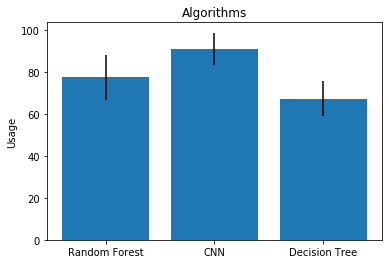

In [35]:
algos = ['Random Forest','CNN','Decision Tree']
y_pos = [0,1,2]
performance=[77.40,90.92,67.30]
std = [10.80,7.80,8.44]
plt.bar(y_pos, performance, align='center', yerr=std)
plt.xticks(y_pos, algos)
plt.ylabel('Usage')
plt.title('Algorithms')
plt.show()

## Model selection based on cross-validation performance
We trained 3 models, random forest, decision tree and convolutional neural network and perform 5 fold cross validation results. From the cross-validation results we see that, CNN model performs best among three classifiers and CNN model achieves f1-score 90.92% whereas random forest and decision tree achieve 77.40% and 67.30% respectively. We also notice that CNN model shown lower error (7.8%) compared to RF and DT. We conclude that our CNN model able to establish correlation among the stastical features and learn inherent patterns accordingly, that helps achieves better perormance.

## CNN model Training 
In this section we, split the training and testing dataset and evaluate our deep CNN model performance against testing datasets. We reported the accuracy, f1 score, precision and recall metrics to evaluate our CNN model performance.

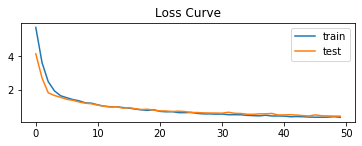

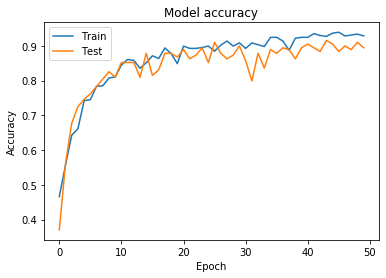

In [31]:


X = df.iloc[:,0:-2]
y = df.iloc[:,-1]
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.20)


trainY=trainY.values

trainX=np.reshape(trainX.values,(trainX.shape[0],trainX.shape[1],1))


testX=np.reshape(testX.values,(testX.shape[0],testX.shape[1],1))

trainY = to_categorical(trainY)

nsamples, nfeatures, n_outputs = trainX.shape[1], trainX.shape[2], 3

verbose, epochs, batch_size = 0, 50, 32
cnn_model = build_cnn(nsamples,nfeatures,n_outputs)
cnn_model = train_cnn(cnn_model,trainX,trainY,epochs= epochs)


## Explanation of CNN performance: 

From the above figure, we notice that with >=30 epochs CNN model converges. From the epoch vs accuracy curve we observe that validation curve closely follow training accuracy curve. After 50 epochs, validation and training accuracy differs 5-6%. That means our CNN model has low variance and low bias.


In [36]:
computing_scores(cnn_model,testX,testY)

Confusion Matrix::
[[ 31  17   1]
 [  6 118   1]
 [  0   1  61]]
Accuracy: 0.889831
Precision: 0.889831
Recall: 0.889831
F1 score: 0.889831


{'acc': 0.8898305084745762,
 'precision': 0.8898305084745762,
 'recall': 0.8898305084745762,
 'f1': 0.8898305084745762,
 'cm': array([[ 31,  17,   1],
        [  6, 118,   1],
        [  0,   1,  61]])}

## Conclusion

Since our CNN model performs best among other machine learning model, we trained CNN model with the training set and test with independent testing set to evauate the performance. We see that CNN model achives 88.98% F1 score. Our predicting classes are neutral (0), stress (1) and amusement (2) respectively. From the confusion matrix, we see that our class distribution are imbalanced therefore we used weighted metric calculation for all the performance metrics. Our classifier shows poor performance on detecting neutral class and around 50% samples are detected as stress. This could happend due to similar signal pattern labeled as neutral or subjects stress levels are different with neutral condition. We also notice that in case of amusement scenario, our model performs better and only a single instance is detected as stress. 